# Librosa demo

This notebook demonstrates some of the basic functionality of librosa version 0.4.

Following through this example, you'll learn how to:

* Load audio input
* Compute mel spectrogram, MFCC, delta features, chroma
* Locate beat events
* Compute beat-synchronous features
* Display features
* Save beat tracker output to a CSV file

In [2]:
# cordinate // Willian
cordinate_samples = [
    (352, 332), (224, 232), (396, 164)
]
cordinate_samples_max = len(cordinate_samples) - 1
cordinate_i = 0
def cordinate_increase():
    global cordinate_i
    if cordinate_i == cordinate_samples_max:
        cordinate_i = 0
    else:
        cordinate_i += 1
    
def cordinate_current():
    global cordinate_i
    return cordinate_samples[cordinate_i]

In [3]:
#audio_path = librosa.util.example_audio_file()

# or uncomment the line below and point it at your favorite song:
#
#audio_path = 'Data/test.wav'
import librosa
import librosa.display
audio_path = "/Users/yanmingjun/Documents/osu-audio-feature-extract/Data/Beatmaps/162800 Linkin Park - Living Things/lt.mp3"


y, sr = librosa.load(audio_path,sr=None)

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib notebook
# We'll need numpy for some mathematical operations
import numpy as np


# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')


# and IPython.display for audio output
import IPython.display


# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

ModuleNotFoundError: No module named 'librosa.filters'

By default, librosa will resample the signal to 22050Hz.

You can change this behavior by saying:
```
librosa.load(audio_path, sr=44100)
```
to resample at 44.1KHz, or
```
librosa.load(audio_path, sr=None)
```
to disable resampling.

# Mel spectrogram
This first step will show how to compute a [Mel](http://en.wikipedia.org/wiki/Mel_scale) spectrogram from an audio waveform.

In [ ]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power as reference.
log_S = librosa.logamplitude(S, ref_power=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

# Harmonic-percussive source separation

Before doing any signal analysis, let's pull apart the harmonic and percussive components of the audio.  This is pretty easy to do with the `effects` module.

In [ ]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

In [ ]:
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.logamplitude(S_harmonic, ref_power=np.max)
log_Sp = librosa.logamplitude(S_percussive, ref_power=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

# Chromagram

Next, we'll extract [Chroma](http://en.wikipedia.org/wiki/Pitch_class) features to represent pitch class information.

In [ ]:
# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

# MFCC

[Mel-frequency cepstral coefficients](http://en.wikipedia.org/wiki/Mel-frequency_cepstrum) are commonly used to represent texture or timbre of sound.

In [ ]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

# Beat tracking

The beat tracker returns an estimate of the tempo (in beats per minute) and frame indices of beat events.

The input can be either an audio time series (as we do below), or an onset strength envelope as calculated by `librosa.onset.onset_strength()`.

In [ ]:
# Now, let's run the beat tracker.
# We'll use the percussive component for this part
onset_env = librosa.onset.onset_strength(y, sr=sr)
plt.figure(figsize=(12, 6))
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

# Let's re-draw the spectrogram, but this time, overlay the detected beats
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(beats),
           1, 0.5 * sr,
           colors='w', linestyles='-', linewidth=2, alpha=0.5)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()

By default, the beat tracker will trim away any leading or trailing beats that don't appear strong enough.  

To disable this behavior, call `beat_track()` with `trim=False`.

In [ ]:
print('Estimated tempo:        %.2f BPM' % tempo)

print('First 5 beat frames:   ', beats[:5])

# Frame numbers are great and all, but when do those beats occur?
print('First 5 beat times:    ', librosa.frames_to_time(beats[:5], sr=sr))

# We could also get frame numbers from times by librosa.time_to_frames()

In [ ]:
# // Willian
beat_timings = librosa.frames_to_time(beats, sr=sr)

for timing in beat_timings:
    cordinate = cordinate_current()
    print("{x},{y},{time},{type},{hitSound},{addition}".format(
        x=cordinate[0],
        y=cordinate[1],
        time=int(timing*1000),
        type=1,
        hitSound=0,
        addition="0:0:0:0:"
    ))
    cordinate_increase()

# Beat-synchronous feature aggregation

Once we've located the beat events, we can use them to summarize the feature content of each beat.

This can be useful for reducing data dimensionality, and removing transient noise from the features.

In [ ]:
# feature.sync will summarize each beat event by the mean feature vector within that beat

M_sync = librosa.util.sync(M, beats)

plt.figure(figsize=(12,6))

# Let's plot the original and beat-synchronous features against each other
plt.subplot(2,1,1)
librosa.display.specshow(M)
plt.title('MFCC-$\Delta$-$\Delta^2$')

# We can also use pyplot *ticks directly
# Let's mark off the raw MFCC and the delta features
plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

plt.colorbar()

plt.subplot(2,1,2)
# librosa can generate axis ticks from arbitrary timestamps and beat events also
librosa.display.specshow(M_sync, x_axis='time',
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

In [ ]:
# Beat synchronization is flexible.
# Instead of computing the mean delta-MFCC within each beat, let's do beat-synchronous chroma
# We can replace the mean with any statistical aggregation function, such as min, max, or median.

C_sync = librosa.util.sync(C, beats, aggregate=np.median)

plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
librosa.display.specshow(C, sr=sr, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time')

plt.title('Chroma')
plt.colorbar()

plt.subplot(2, 1, 2)
librosa.display.specshow(C_sync, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time', 
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))


plt.title('Beat-synchronous Chroma (median aggregation)')

plt.colorbar()
plt.tight_layout()

# Dynamic Tempo

In [7]:
onset_env = librosa.onset.onset_strength(y, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
tempo

array([ 129.19921875])

In [8]:
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr,
                            aggregate=None)
dtempo

array([  86.1328125 ,   86.1328125 ,   86.1328125 , ...,  129.19921875,
        129.19921875,  129.19921875])

In [10]:
set(dtempo)

{86.1328125,
 89.102909482758619,
 117.45383522727273,
 123.046875,
 129.19921875,
 135.99917763157896,
 143.5546875,
 151.99908088235293}

In [ ]:
hop_length = 512
plt.figure(figsize=(12,6))
tg = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr,
                               hop_length=hop_length)
librosa.display.specshow(tg, x_axis='time', y_axis='tempo')
plt.plot(librosa.frames_to_time(np.arange(len(dtempo))), dtempo,
         color='w', linewidth=1.5, label='Tempo estimate')
plt.title('Dynamic tempo estimation')
plt.legend(frameon=True, framealpha=0.75)
plt
# Error

# Onsets

In [4]:
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

array([   1.04489796,    1.50929705,    1.7414966 ,    2.90249433,
          3.41333333,    3.59909297,    4.08671202,    4.59755102,
          4.80653061,    5.0155102 ,    5.27092971,    5.52634921,
          5.71210884,    5.89786848,    6.45514739,    6.66412698,
          6.87310658,    7.15174603,    7.36072562,    7.61614512,
          7.84834467,    8.31274376,    8.52172336,    8.87002268,
          8.98612245,    9.42730159,    9.58984127,    9.729161  ,
         10.03102041,   10.19356009,   10.56507937,   10.68117914,
         10.89015873,   11.02947846,   11.14557823,   11.37777778,
         11.49387755,   11.58675737,   11.84217687,   11.95827664,
         12.05115646,   12.28335601,   12.39945578,   12.53877551,
         12.77097506,   13.0031746 ,   13.28181406,   13.42113379,
         13.95519274,   14.16417234,   14.37315193,   14.67501134,
         14.88399093,   15.04653061,   15.09297052,   15.34839002,
         15.81278912,   16.06820862,   16.27718821,   16.55582

In [5]:
o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

<IPython.core.display.Javascript object>


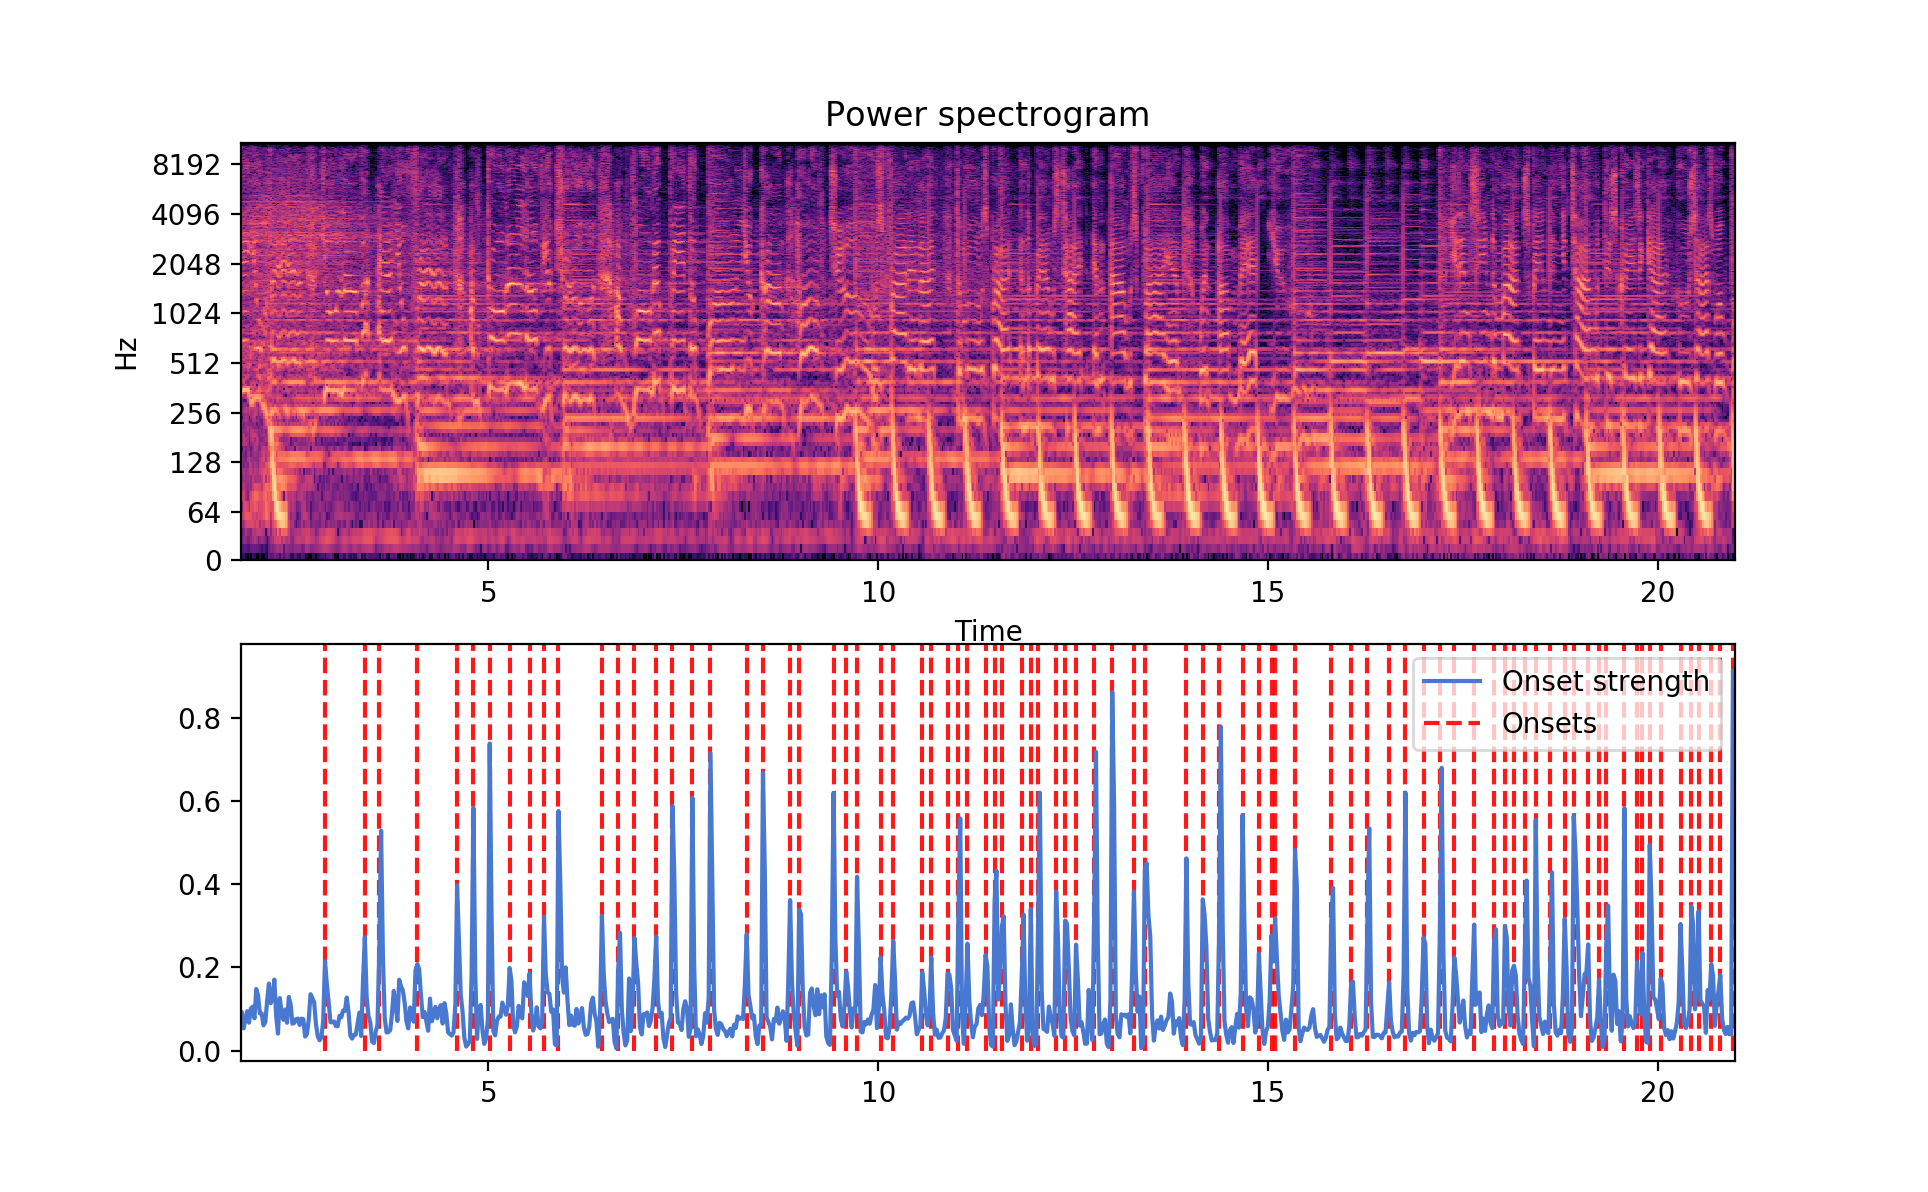

In [6]:
 D = librosa.stft(y)
plt.figure(figsize=(12,12))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)
